In [2]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr

In [3]:
# Open ERA5 dataset; change name accordingly to yours
ds = xr.open_dataset('EU_MESOSCALE_SL.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 33, latitude: 29, time: 24)
Coordinates:
  * longitude  (longitude) float32 117.0 117.2 117.5 117.8 ... 124.5 124.8 125.0
  * latitude   (latitude) float32 20.0 19.75 19.5 19.25 ... 13.5 13.25 13.0
  * time       (time) datetime64[ns] 2016-08-14 ... 2016-08-14T23:00:00
Data variables:
    v100       (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    cape       (time, latitude, longitude) float32 ...
    cin        (time, latitude, longitude) float32 ...
    i10fg      (time, latitude, longitude) float32 ...
    kx         (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    totalx     (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-24 08:52:47 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [4]:
# Grab lat/lon values (NAM will be 2D)
lats = ds['latitude']
lons = ds['longitude']

# Select and grab data
mslp = ds.msl
ugust = ds.i10fg # Proxy as U-component Gust
vgust = ds.v100 # Proxy as V-component Gust
tti = ds.totalx

# Select and grab MSLP. Apply gaussian_filter.
mslp = gaussian_filter(mslp.data[8], sigma=3.0) * units.pascal
mslph = mslp.to('hPa')

# Select wind components of gustiness
uwnd_gust = gaussian_filter(ugust.data[8], sigma=3.0) * units('m/s') 
vwnd_gust = gaussian_filter(vgust.data[8], sigma=3.0) * units('m/s')

# Apply gaussian smoothing in Totals Total Index 
tindex = gaussian_filter(tti.data[8], sigma=3.0) * units('K') 

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds.time.data[8].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

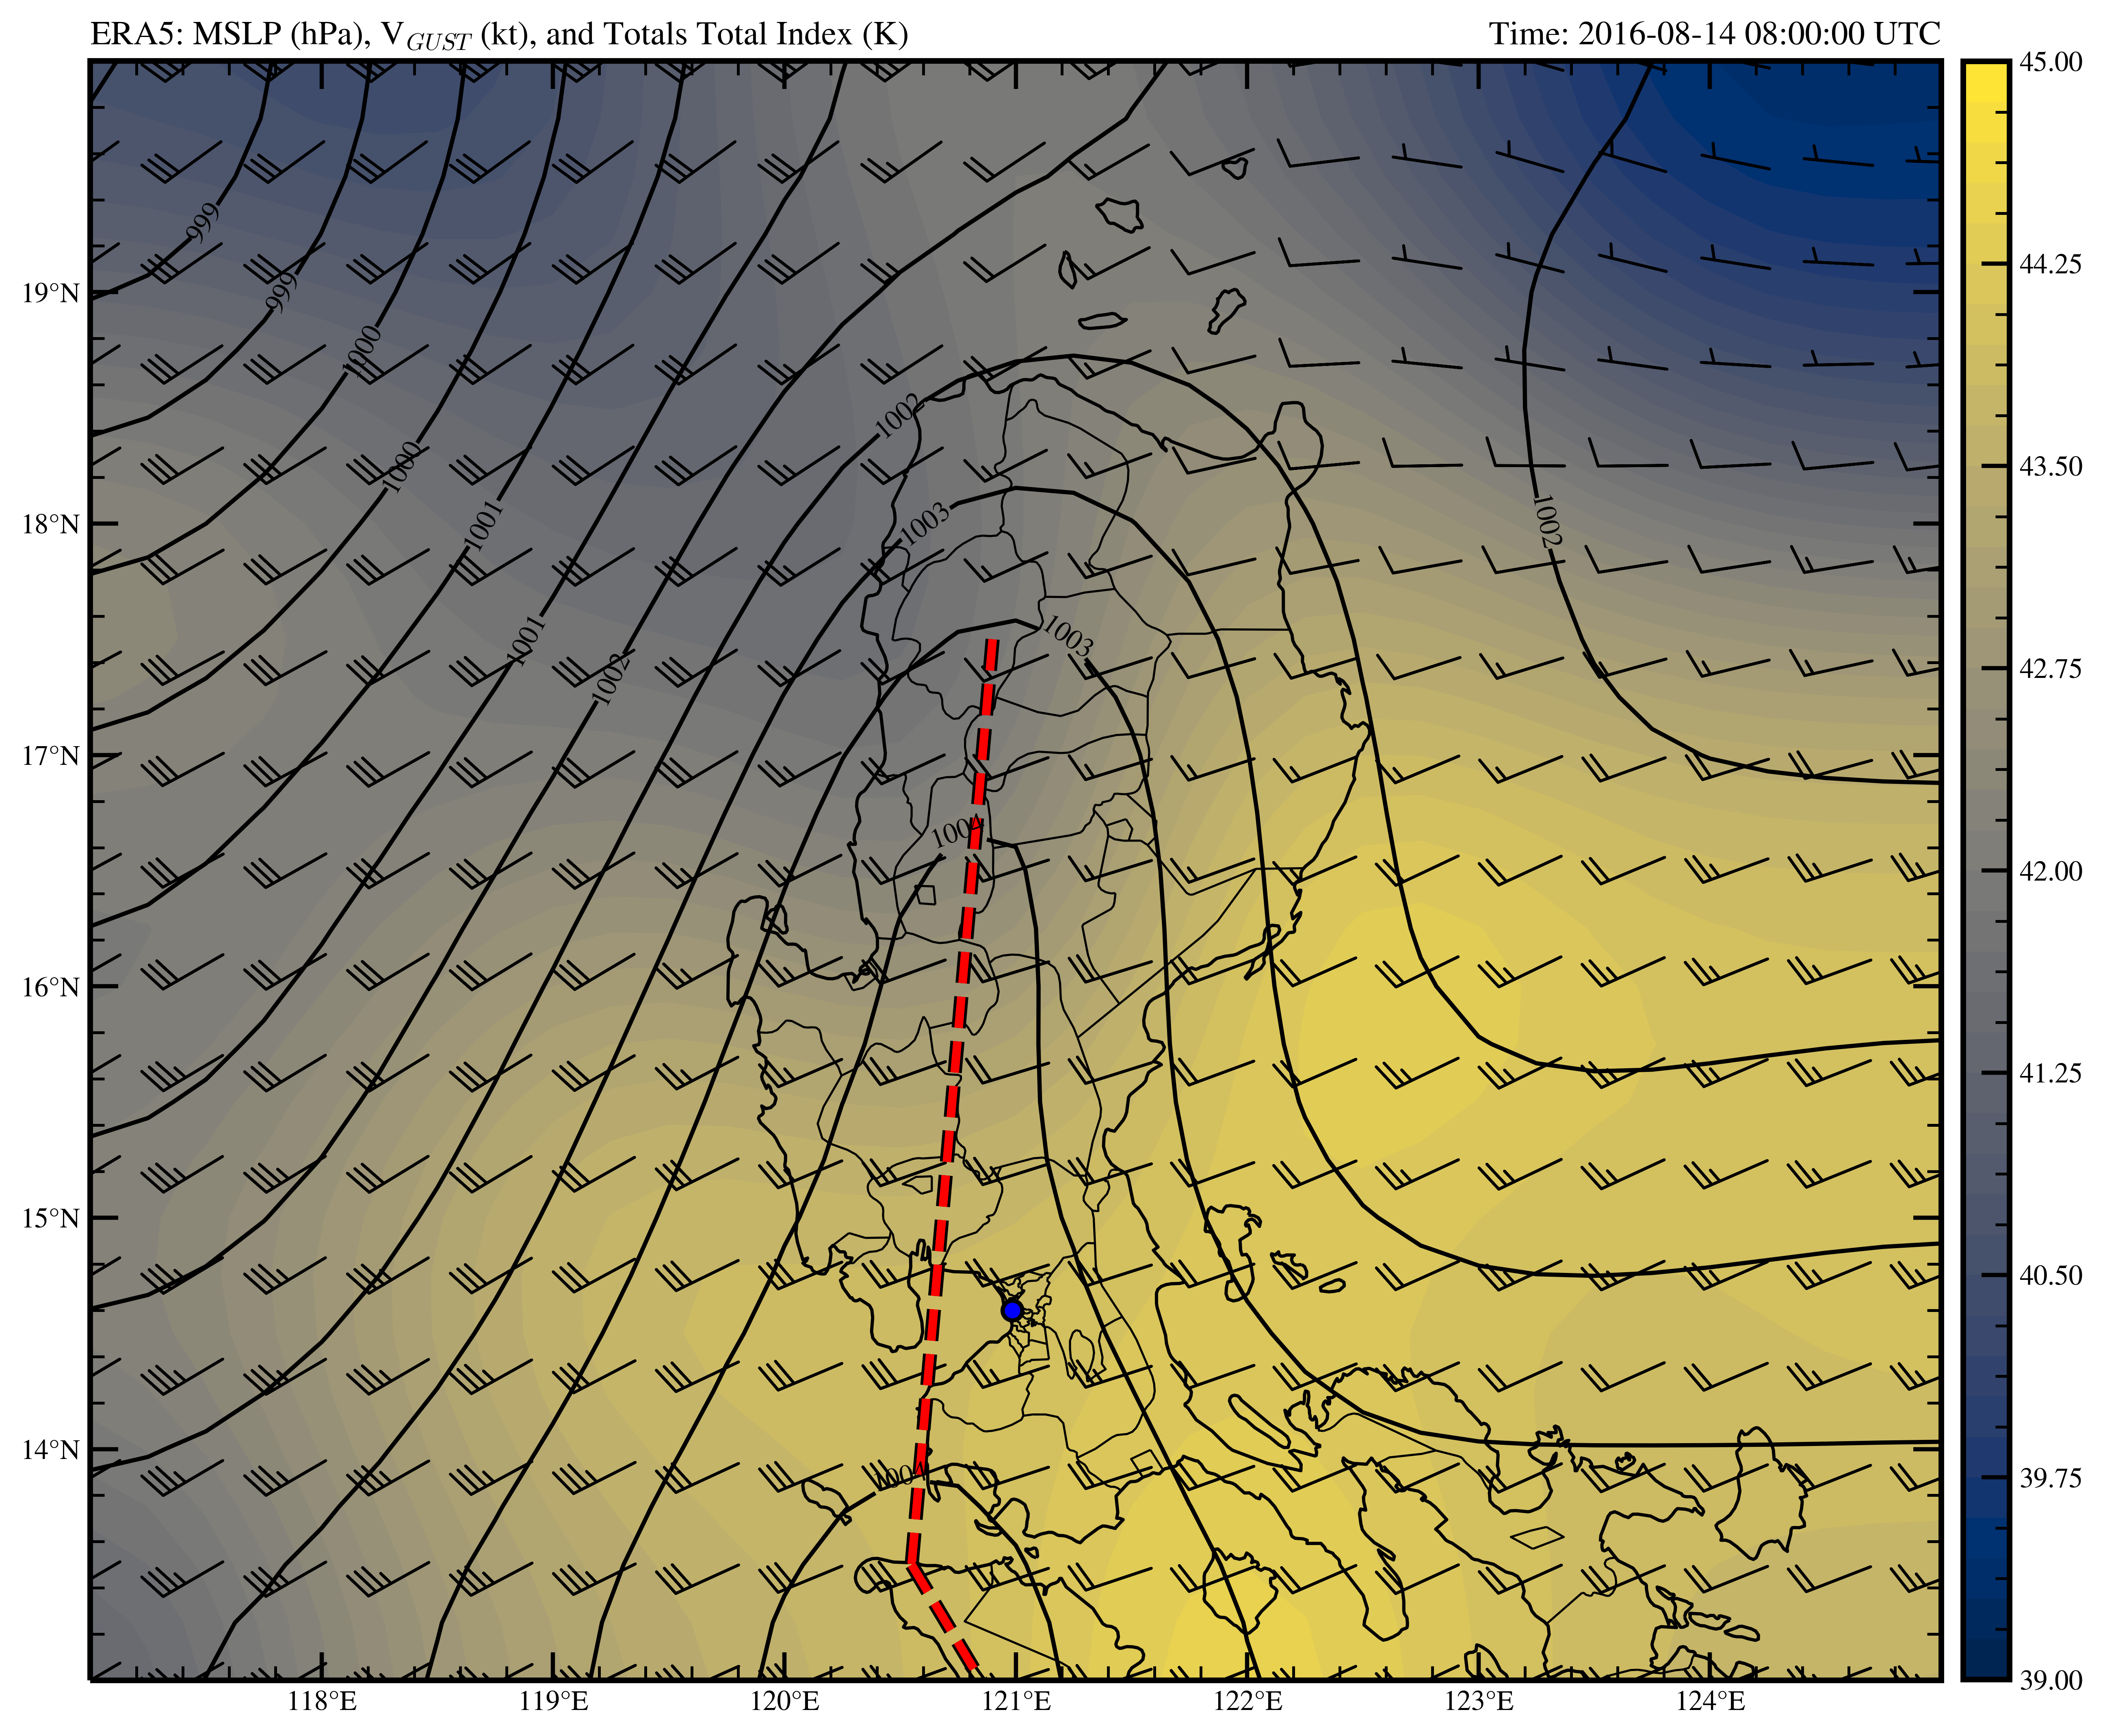

In [8]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.PlateCarree()

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=datacrs)
ax.set_extent([117, 125, 13, 20], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', 
                                                scale='10m', facecolor='none', linewidth=0.75)
ax.add_feature(states_provinces, edgecolor='k')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.15)
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.add_feature(cfeature.LAND)

# Add Totals Total Index Contours
tix_range = np.arange(39, 45.15, 0.15)
ti = ax.contourf(lons, lats, tindex, tix_range, cmap='cividis', transform=datacrs)
cbar = plt.colorbar(ti, orientation='vertical', pad=0.01, aspect=35, shrink=0.664)
cbar.ax.minorticks_on()
cbar.ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
cbar.ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Add Gustiness using U and V-component proxies
ax.barbs(lons, lats, uwnd_gust.to('kt').m, vwnd_gust.to('kt').m, pivot='middle',
         color='black', regrid_shape=17, transform=datacrs)

# Plot MSLP Contour
MSLP_range = np.arange(998, 1005, 0.5)
prs = ax.contour(lons, lats, mslph, MSLP_range, colors='k',
                 transform=datacrs, zorder=1)
ax.clabel(prs, fmt='%d')

# Create a line(s) that highlights the surface trough
outline=pe.withStroke(linewidth=5, foreground='k')

point1 = dict(lon=120.90, lat=17.50)
point2 = dict(lon=120.55, lat=13.50)
lon_p = [point1['lon'], point2['lon']]
lat_p = [point1['lat'], point2['lat']]
ax.plot(lon_p, lat_p, color='red', lw=3, ls='--',
        path_effects=[outline, pe.Normal()], transform=ccrs.Geodetic())

point3 = dict(lon=120.55, lat=13.50)
point4 = dict(lon=122.40, lat=10.40)
lon_p1 = [point3['lon'], point4['lon']]
lat_p1 = [point3['lat'], point4['lat']]
ax.plot(lon_p1, lat_p1, color='red', lw=3, ls='--', 
        path_effects=[outline, pe.Normal()], transform=ccrs.Geodetic())

# Make some nice titles for the plot (one right, one left)
ax.set_title('ERA5: MSLP (hPa), V$_{GUST}$ (kt), and Totals Total Index (K)', loc='left')
ax.set_title('Time: {} UTC'.format(vtime), loc='right')

# Add marker of Manila, NCR via its lats and lons
manila_lon, manila_lat = 120.9842, 14.5995
ax.plot(manila_lon, manila_lat, color='blue', markersize=7, 
        markeredgewidth=1.5, markeredgecolor='k', marker='o', transform=datacrs)

# Set X and Y-ticks for Latitude and Longitude Coordinates
ax.set_yticks(lats, 5, crs=ccrs.PlateCarree())
ax.set_xticks(lons, 5, crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
long_formatter = cticker.LongitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_major_formatter(long_formatter)
ax.set_xticks(ax.get_xticks()[1:8]) #Hide end points of longitude tickmarks
ax.set_yticks(ax.get_yticks()[1:7]) #Hide end points of latitude tickmarks
ax.minorticks_on() 
ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.savefig('MLSP, Zgust, TIX.jpg', bbox_inches="tight")
plt.show()